In [1]:
import pydicom
import numpy as np
from skimage.transform import resize,rescale
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import os
import pandas as pd

# hough ellipse transform
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse, resize
from skimage.draw import ellipse_perimeter
from skimage.color import gray2rgb
import skimage.io as io

# inmediate data process
from utils import normalize, get_rois, plot_axis, read_data
from utils import read_rois_and_axis_data

# segmentation
from segmentation_model import unet_model

# detection
from detection_model import Net, num_classes
from detection_machine import Detection

# registration
from registration_machine import Semi_auto_registration

# hyperparameters
from utils import input_size, img_height, img_width

# Detection Part

In [2]:
root_path = 'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_brut'
ims_T1sag, ims_T1, ims_T2sag, ims_T2, ims_T2star, pos,_,_,_ = read_data(root_path, if_normalized=True)

In [3]:
inds = []
infos = [
    ('Brebis 7', 'J-7'),
    ('Brebis 8', 'J-7'),
    ('Brebis 9', 'J-7'),
]

for j,info in enumerate(infos):
    for i,p in enumerate(pos):
        is_find = False
        if p.find(info[0]) is not -1 and p.find(info[1]) is not -1:
            inds.append(i)
            is_find = True
            break
    if is_find is False:
        print(infos[j], 'not found!')  

In [4]:
# detection part
net = Net(num_classes)
net.load_weights(filepath="./detection_model_weights/save_model_weights_36x36.ckpt")

ims = ims_T1sag[inds]

chosen_rate = 1 - 1e-1
detection_machine = Detection(net, ims, input_size)
detection_machine.operate(chosen_rate)

OPERATING
time consuming:  0:00:23.350558


In [5]:
dir_rois = r'.\intermediate_results'
rois_ens = detection_machine.read_and_save_rois(dir_rois)
rois_axis_ens = detection_machine.read_and_save_rois_axis(dir_rois)

READING AND SAVING ROI
Rois figures saved to .\intermediate_results successfully
READING AND SAVING ROI AXIS
Rois axis npy file saved to .\intermediate_results successfully


In [6]:
inds

[58, 63, 68]

The inds will be used afterwards in the segmentation parts

# Segmentation Part

In [7]:
# read rois imgs and rois_axis_ens from the detextion result
dir_rois = r'.\intermediate_results'
rois_ens, rois_axis_ens = read_rois_and_axis_data(dir_rois)

# 对于 rois data 的 pre process
copy = rois_ens.copy()
for i,rois in enumerate(copy): 
    rois = resize(rois.transpose(1,2,0), (img_height, img_width)).transpose(2,0,1)  
    rois = normalize(rois)        # 先normalization变成0到1
    rois = rois[:,:,:,np.newaxis]
    rois_ens[i] = rois
print(rois_ens[0].shape, rois_ens[0].dtype)

# 对于 axis 的 pre process
copy = rois_axis_ens.copy()
for i,rois_axis in enumerate(copy): 
    rois_axis[:,[1,0]] = rois_axis[:,[0,1]]  # 交换一下x和y的位置
    rois_axis = np.concatenate((rois_axis, np.array(input_size)[:,np.newaxis].repeat(rois_axis.shape[0], axis=1).T), axis=1)
    rois_axis_ens[i] = rois_axis
print(rois_axis_ens[0].shape, rois_axis_ens[0].dtype)

(7, 128, 128, 1) float32
(7, 4) int64


In [8]:
# segmentation models loading
input_shape = (img_height, img_width)

## mid
modified_input_size = (img_height, img_width,1)
model1 = unet_model(input_size = modified_input_size)
model1.load_weights("./segmentation_model_weights/weights_unet1.hdf5")

## both sides
model2 = unet_model(input_size = modified_input_size)
model2.load_weights("./segmentation_model_weights/weights_unet2.hdf5")

In [9]:
Y1_pred = []
Y2_pred = []
for rois, rois_axis in zip(rois_ens, rois_axis_ens):
    y1_pred = model1.predict(rois).squeeze()
    y2_pred = model2.predict(rois).squeeze()
    
    y1_pred = resize(y1_pred.transpose(1,2,0), input_size).transpose(2,0,1)  
    y2_pred = resize(y2_pred.transpose(1,2,0), input_size).transpose(2,0,1) 
    
    Y1_pred.append(y1_pred)
    Y2_pred.append(y2_pred)
print(Y1_pred[0].shape)
print(Y2_pred[0].shape)

(7, 36, 36)
(7, 36, 36)


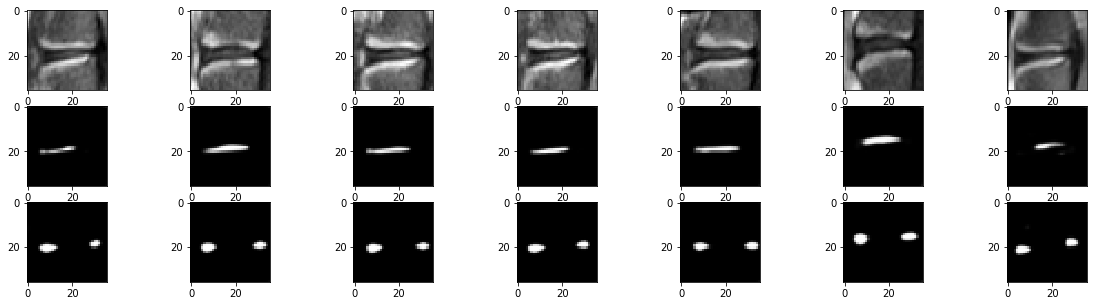

In [93]:
# show the first exemple 
rank = 0
N = Y1_pred[rank].shape[0]
plt.figure(figsize=(20,5))
for i in range(N):
    plt.subplot(3,N,i+1)
    plt.imshow(resize(rois_ens[rank][i].squeeze(),Y1_pred[rank][i].shape), cmap = 'gray')
    
    plt.subplot(3,N,i+N+1)
    plt.imshow(Y1_pred[rank][i],cmap = 'gray')
    
    plt.subplot(3,N,i+2*N+1)
    plt.imshow(Y2_pred[rank][i],cmap = 'gray')
plt.show()

# Registration Part

In [114]:
threshold = 0.3

In [115]:
# recalage semi-automatique et recherche de valeur
root_path = 'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_brut'
ims_T1sag, ims_T1, ims_T2sag, ims_T2, ims_T2star, pos, axis_ens_T1, axis_ens_T2, axis_ens_T2star = read_data(root_path, if_normalized=True)
_, ims_T1, _, ims_T2, ims_T2star, _, _, _, _ = read_data(root_path, if_normalized=False) # 读取没有normalization的数据

inds = [58, 63, 68]
names = []
for i in inds:
    p = pos[i]
    name = p[p.find('Brebis'):p.find('Brebis')+21]
    names.append(name)
#print(names)

test_T1 = ims_T1[inds]
test_T2 = ims_T2[inds]
test_T2star = ims_T2star[inds]
test_axis_ens_T1 = axis_ens_T1
test_axis_ens_T2 = axis_ens_T2
test_axis_ens_T2star = axis_ens_T2star

In [116]:
segmentation_model = Semi_auto_registration(Y1_pred, Y2_pred, rois_axis_ens, input_size, test_T1, 
                                            test_T2, test_T2star, test_axis_ens_T1, test_axis_ens_T2, test_axis_ens_T2star)
rois_ens_T1, Y1_pred_T1, Y2_pred_T1 = segmentation_model.get_rois('T1')

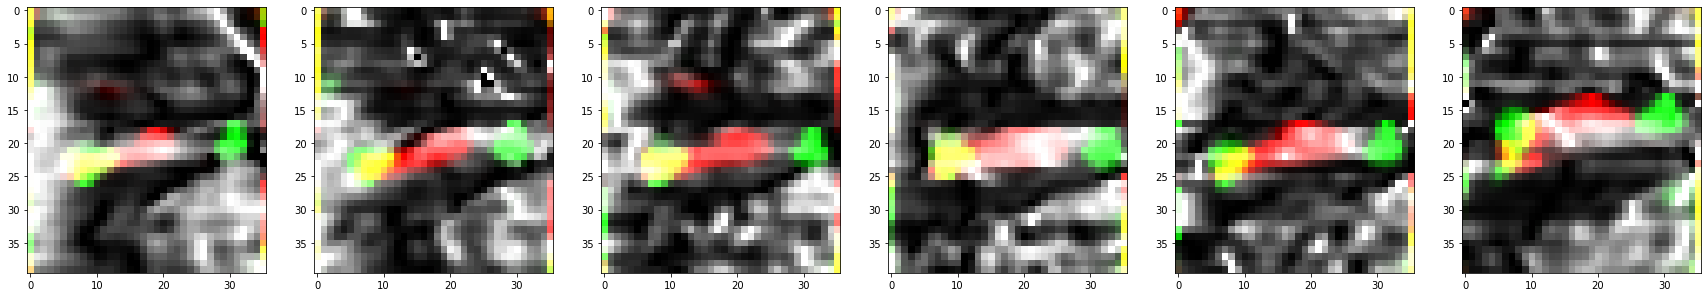

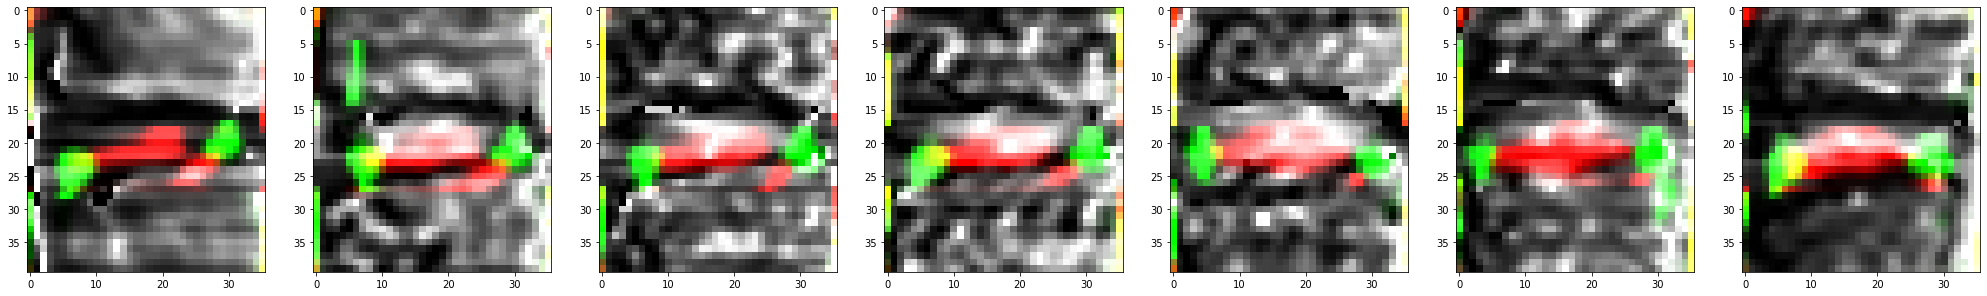

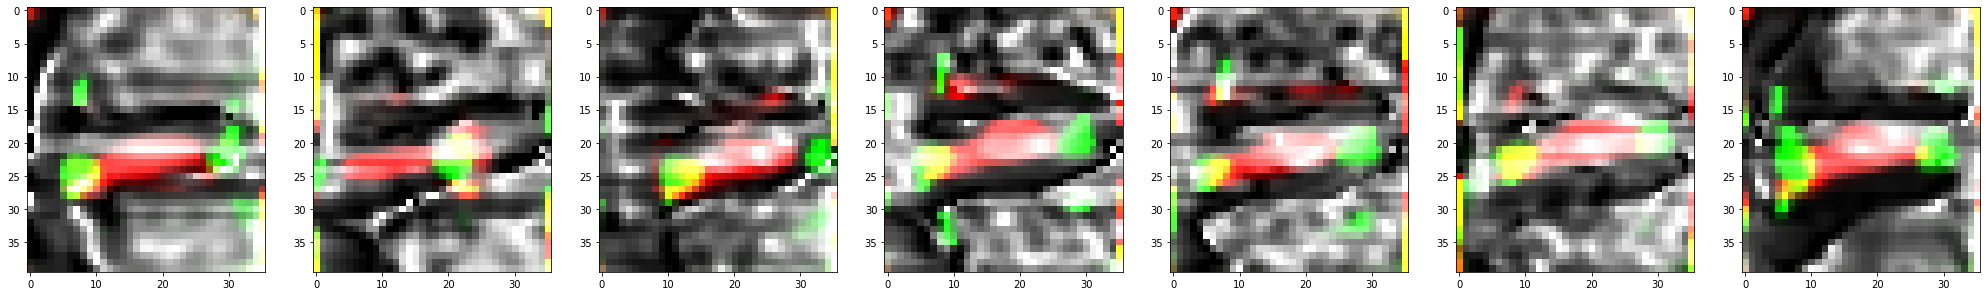

In [117]:
# see the superposition
for rois, y1_pred, y2_pred in zip(rois_ens_T1, Y1_pred_T1, Y2_pred_T1):
    plt.figure(figsize= (5*rois.shape[0],5))
    for i,(roi, y1_p, y2_p) in enumerate(zip(rois, y1_pred, y2_pred)):
        #print(y1_pred.mean(),y1_pred.max(), y1_pred.min())
        #print(roi.mean(), roi.max(), roi.min())
        roi_copy = gray2rgb(normalize(roi))
        roi_copy[:,:,0] += normalize(y1_p)
        roi_copy[:,:,1] += normalize(y2_p)
        
        plt.subplot(1, rois.shape[0], i+1)
        plt.imshow(roi_copy.squeeze())

In [118]:
def ims_size_match(ims, tgt_size):
    '''resize, 对每一个im单独resize(for 循环)， 因为ims里面的im 的size可能本来就不一样, resize之后强行转换为float格式(int16->float64)'''
    new_ims = []
    for im in ims:
        im = resize(im, tgt_size)
        new_ims.append(im)
    return np.array(new_ims)

In [119]:
dir_result = r'.\results'
if not os.path.exists(dir_result):
    os.makedirs(dir_result)

In [120]:
segmentation_model = Semi_auto_registration(Y1_pred, Y2_pred, rois_axis_ens, input_size, test_T1, 
                                            test_T2, test_T2star, test_axis_ens_T1, test_axis_ens_T2, test_axis_ens_T2star)
rois_ens_T1, Y1_pred_T1, Y2_pred_T1 = segmentation_model.get_rois('T1')
data_pred1 = segmentation_model.get_values(rois_ens_T1, Y1_pred_T1, Y2_pred_T1, th=threshold)
data_pred1.to_csv(r'.\results\T1.csv') # 保存为csv
#print(data_pred1)

In [121]:
rois_ens_T2, y1_pred_T2, y2_pred_T2 = segmentation_model.get_rois('T2')
data_pred2 = segmentation_model.get_values(rois_ens_T2, y1_pred_T2, y2_pred_T2, th=threshold)
data_pred2.to_csv(r'.\results\T2.csv') # 保存为csv
#print(data_pred2)

Brebis 7 (40560)\J-7\


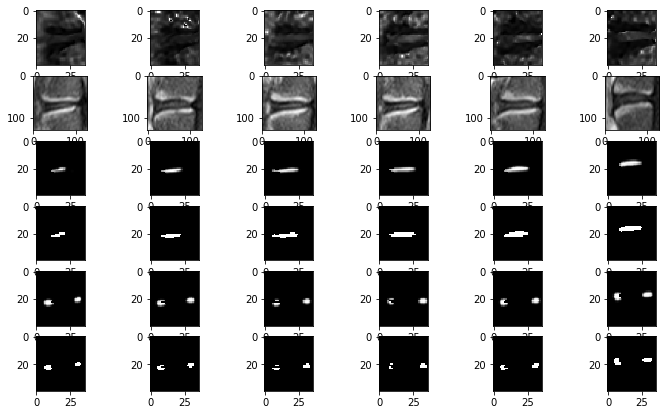

Brebis 8 (40141)\J-7\


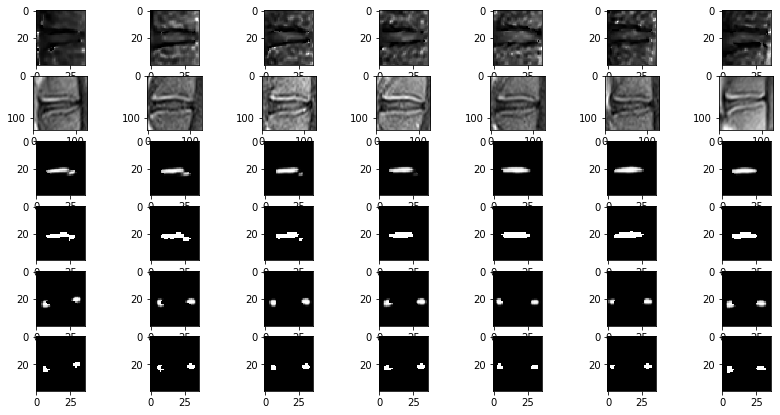

Brebis 9 (40295)\J-7\


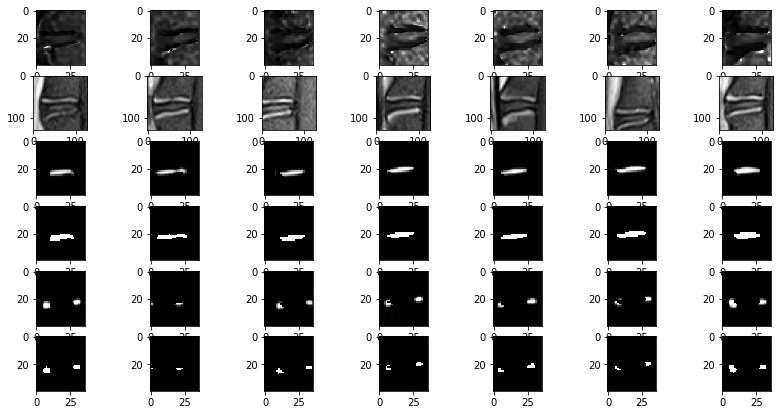

In [122]:
segmentation_model.draw_figures(rois_ens_T1, Y1_pred_T1, Y2_pred_T1, th=threshold)

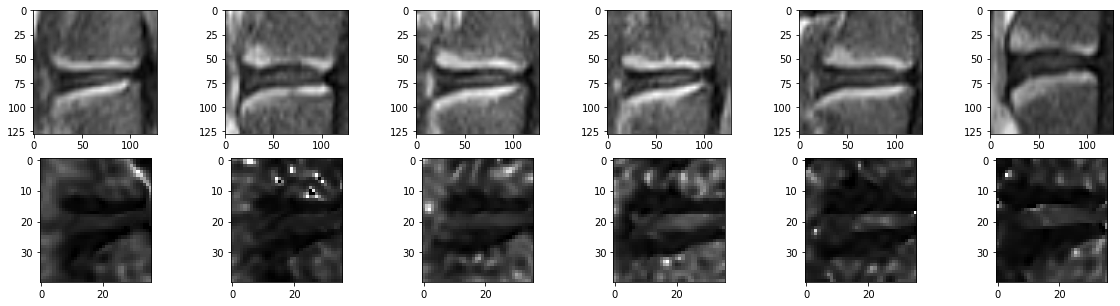

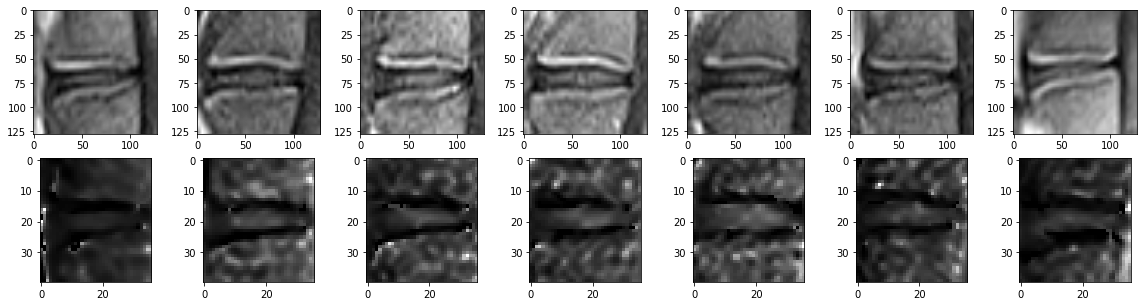

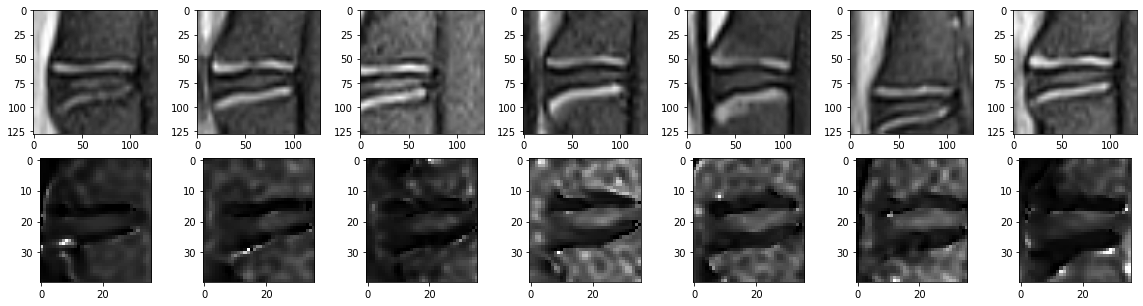

In [123]:
for i in range(len(inds)):
    plt.figure(figsize=(20,5))
    N = rois_ens_T1[i].shape[0]
    for j in range(N):
        plt.subplot(2,N,j+1)
        plt.imshow(rois_ens[i][j].squeeze(), cmap = 'gray')
        
        plt.subplot(2,N,j+N+1)
        plt.imshow(rois_ens_T1[i][j],cmap = 'gray')
    plt.show()